<a href="https://colab.research.google.com/github/Kenz2000/Deep-Learning-project/blob/main/VAT_Method_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pydot
%matplotlib inline
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Input, Dense, GaussianNoise, Dropout, BatchNormalization, ReLU, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import History

from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
tf.keras.backend.set_floatx('float64') #Change numerical type to 'float64'
#Load the data
from keras.datasets import mnist
(x_train_original, y_train_original), (x_test, y_test) = mnist.load_data()
num_classes = y_train_original.max() +1 #number of labels
y_train = to_categorical(y_train_original, num_classes)
y_test = to_categorical(y_test, num_classes)
#Normalize the data
x_train = x_train_original/255
x_test = x_test/255
#Train-test split
from sklearn.model_selection import train_test_split
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(x_train, y_train,
test_size=59900, random_state=42, shuffle= True,stratify=y_train)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)
print("x_labeled.shape", x_labeled.shape)
print("x_unlabeled.shape", x_unlabeled.shape)

x_train.shape (60000, 28, 28)
y_train.shape (60000, 10)
x_test.shape (10000, 28, 28)
y_test.shape (10000, 10)
x_labeled.shape (100, 28, 28)
x_unlabeled.shape (59900, 28, 28)


In [5]:
n_filters = 5
kernel_size = 5
pool_size = 2
n_classes = 10

Baseline_model = Sequential([
    Conv2D(n_filters,
                  kernel_size,
                  activation='relu',
                  input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(10, activation="relu"),
    Dense(n_classes, activation='softmax')
])

In [6]:
Baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 5)         130       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 5)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 10)                7210      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 7450 (58.20 KB)
Trainable params: 7450 (58.20 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

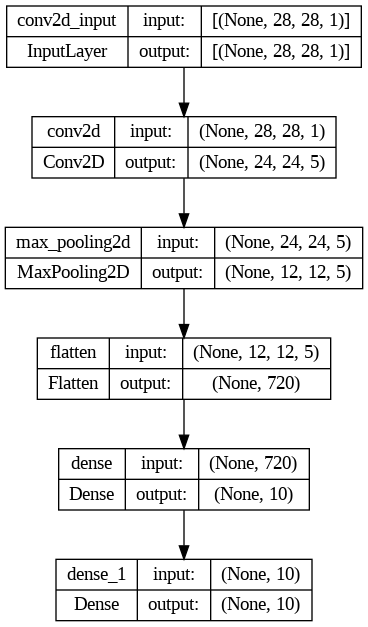

In [8]:
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(Baseline_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
Baseline_model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])
history = Baseline_model.fit(x_labeled, y_labeled, batch_size=128,
         epochs=1000,  # trick to make number of batch updates similar to that of the semi-supervised model
         verbose=2)

Epoch 1/1000
1/1 - 10s - loss: 2.2919 - accuracy: 0.0800 - 10s/epoch - 10s/step
Epoch 2/1000
1/1 - 0s - loss: 2.2661 - accuracy: 0.1200 - 15ms/epoch - 15ms/step
Epoch 3/1000
1/1 - 0s - loss: 2.2409 - accuracy: 0.1600 - 13ms/epoch - 13ms/step
Epoch 4/1000
1/1 - 0s - loss: 2.2158 - accuracy: 0.1900 - 11ms/epoch - 11ms/step
Epoch 5/1000
1/1 - 0s - loss: 2.1907 - accuracy: 0.2400 - 12ms/epoch - 12ms/step
Epoch 6/1000
1/1 - 0s - loss: 2.1652 - accuracy: 0.2700 - 13ms/epoch - 13ms/step
Epoch 7/1000
1/1 - 0s - loss: 2.1378 - accuracy: 0.3500 - 14ms/epoch - 14ms/step
Epoch 8/1000
1/1 - 0s - loss: 2.1097 - accuracy: 0.3300 - 14ms/epoch - 14ms/step
Epoch 9/1000
1/1 - 0s - loss: 2.0813 - accuracy: 0.3600 - 10ms/epoch - 10ms/step
Epoch 10/1000
1/1 - 0s - loss: 2.0530 - accuracy: 0.3900 - 14ms/epoch - 14ms/step
Epoch 11/1000
1/1 - 0s - loss: 2.0251 - accuracy: 0.3900 - 10ms/epoch - 10ms/step
Epoch 12/1000
1/1 - 0s - loss: 1.9977 - accuracy: 0.4300 - 12ms/epoch - 12ms/step
Epoch 13/1000
1/1 - 0s - l

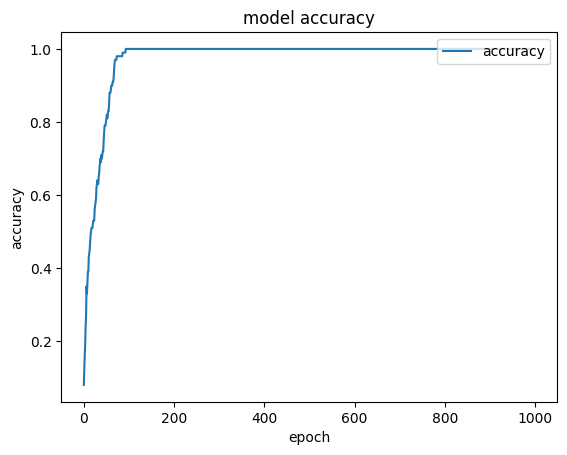

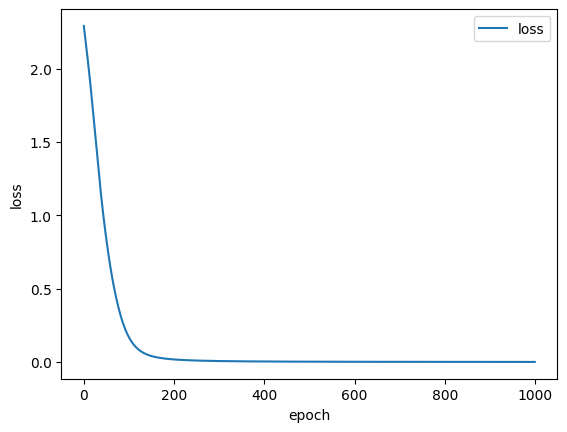

In [10]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.legend(['loss'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [11]:
Baseline_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.6895 - accuracy: 0.6975


[1.689541718513383, 0.6975]

In [12]:
# Function for calculating the KL divergence of 2 distributions from output logit of the neural network
def KL_divergence(p_logit, q_logit, value_min = 1e-30):
  #Input: p_logit, q_logit : logit values
  # value_min: to prevent log(probability) = -inf when the probability is too small
  #Output: KL divergence of p_logit and q_logit
      p = tf.nn.softmax(p_logit)
      q = tf.nn.softmax(q_logit)
      return tf.reduce_sum(p*(tf.math.log(p + value_min) - tf.math.log(q + value_min)), axis=1)



# Function to obtain a unit vector
def normalization(d):
    #Input: d: a vector
    #Output: an unit vector having same direction as d
      d = d/(1e-15 + tf.reduce_max(tf.abs(d), range(1, len(d.get_shape())), keepdims=True))
      norm_d = tf.norm(d+1e-15,axis=[1,2])
      return (d+1e-15) / tf.reshape(norm_d, [d.shape[0],1,1])



#Function for generating the data with virtual adversarial pertubation
def generator(x, psi, epsilon):
    #Input: x: original input data
    # psi: small number
    # epsilon: norm of the pertubation term
    #Output: add the virtual adversarial pertubation back into the original input
      r = psi * normalization(tf.random.normal(shape=tf.shape(x), dtype=tf.float64))
      with tf.GradientTape() as tape:
        tape.watch(r)
        p_logit = VAT_model(x)
        p_logit_r = VAT_model(x + r)
        kl = tf.reduce_mean(KL_divergence(p_logit , p_logit_r))
      grad = tape.gradient(kl, r)
      return x + epsilon * normalization(grad)


#Function for calculating the virtual adversarial pertubation loss
def pertubation_loss(p_logit, p_logit_r):
    #Input: p_logit: logit value of train data
    # p_logit_r: logit value of train data with virtual adversarial pertubation
    #Output: R_vadv of p_logit and p_logit_r
      return tf.reduce_mean(KL_divergence(p_logit, p_logit_r))

#Function for calculating the cross entropy loss of the labeled data
def cross_entropy_loss(y_labeled, logit_labeled):
    #Input: y_labled: true value of output
    # logit_labeled: predicted logit value for labeled data
    #Output: Categorical Cross-Entropy Loss
      return tf.keras.losses.CategoricalCrossentropy(from_logits=True).call(y_labeled, logit_labeled)


#Calculate the total loss of VAT
def vat_loss(logit_p, logit_p_r, y_labeled, logit_labeled, alpha = 1):
  #vat_loss = alpha * pertubation_loss + cross_entropy_loss
  return pertubation_loss(logit_p, logit_p_r) * alpha + cross_entropy_loss(y_labeled, logit_labeled)

In [13]:
n_filters = 5
kernel_size = 5
pool_size = 2
n_classes = 10

VAT_model = Sequential([
    Conv2D(n_filters,
                  kernel_size,
                  activation='relu',
                  input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(10, activation="relu"),
    Dense(n_classes, activation='softmax')

])

In [14]:
#Implement the network and setting hyperparameters for trainning
x_train = tf.constant(x_train, dtype = tf.float64)
x_labeled = tf.constant(x_labeled, dtype = tf.float64)
EPOCHS = 200 #number of epochs
BATCH_SIZE = 256
BUFFER_SIZE = 60000
DISPLAY_STEP = 1
epsilon = 1e-1
psi = 1e-6
alpha = 2.0
lnr = tf.keras.optimizers.schedules.PolynomialDecay(
initial_learning_rate = 0.0001, decay_steps=100000, end_learning_rate=0.0000001, power=1.0,
cycle=False, name=None) #learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lnr) #optimizer

#Implement training loop
@tf.function
def train_step(x_train, x_labeled, y_labeled):
  x_gen = generator(x_train, psi, epsilon) #generate virtual perturbation
  with tf.GradientTape() as tape:
    tape.watch(VAT_model.trainable_weights)
    logit_p = VAT_model(x_train)
    logit_p_r = VAT_model(x_gen)
    logit_labeled = VAT_model(x_labeled)
    loss = vat_loss(logit_p, logit_p_r, y_labeled, logit_labeled, alpha)
  grad = tape.gradient(loss, VAT_model.trainable_weights)
  #minimize total loss by updating weight parameters of the neural VAT_model
  optimizer.apply_gradients(zip(grad, VAT_model.trainable_weights))


#Create training batch and shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
Total_loss = []
Pertubation_loss = []
Cross_entropy_loss = []
Test_accuracy = []
Epoch = []
for epoch in tqdm(np.arange(0,EPOCHS)):
    for image_batch in train_dataset:
        train_step(image_batch, x_labeled, y_labeled)


    if (epoch % DISPLAY_STEP == 0 ) or epoch == 0 or (epoch==EPOCHS-1):
        #Calculate loss functions
        x_gen = generator(x_train, psi, epsilon)
        logit_p = VAT_model(x_train)
        logit_p_r = VAT_model(x_gen)
        logit_labeled = VAT_model(x_labeled)
        per_loss = pertubation_loss(logit_p, logit_p_r)
        cross_loss = cross_entropy_loss(y_labeled, logit_labeled)
        loss = vat_loss(logit_p, logit_p_r, y_labeled, logit_labeled, alpha)
        #Prediction on test set
        logit_test = VAT_model(x_test)
        test_acc = sum(np.argmax(logit_test, 1)-np.argmax(y_test,1)==0) / 10000
        #Save perfomance
        Epoch = np.append(Epoch, epoch)
        Total_loss = np.append(Total_loss, loss.numpy())
        Pertubation_loss = np.append(Pertubation_loss, per_loss.numpy())
        Cross_entropy_loss = np.append(Cross_entropy_loss, cross_loss.numpy())
        Test_accuracy = np.append(Test_accuracy, test_acc)
        print(test_acc) #Print result for each epoch

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  0%|          | 1/200 [00:19<1:03:35, 19.17s/it]

0.3891


  1%|          | 2/200 [00:22<33:19, 10.10s/it]  

0.5752


  2%|▏         | 3/200 [00:26<23:29,  7.15s/it]

0.7034


  2%|▏         | 4/200 [00:30<18:46,  5.75s/it]

0.7263


  2%|▎         | 5/200 [00:33<16:14,  5.00s/it]

0.7318


  3%|▎         | 6/200 [00:37<14:39,  4.53s/it]

0.7354


  4%|▎         | 7/200 [00:41<13:33,  4.21s/it]

0.7375


  4%|▍         | 8/200 [00:44<12:49,  4.01s/it]

0.739


  4%|▍         | 9/200 [00:48<12:24,  3.90s/it]

0.7397


  5%|▌         | 10/200 [00:51<12:00,  3.79s/it]

0.7401


  6%|▌         | 11/200 [00:55<11:43,  3.72s/it]

0.7407


  6%|▌         | 12/200 [00:58<11:31,  3.68s/it]

0.7419


  6%|▋         | 13/200 [01:02<11:28,  3.68s/it]

0.742


  7%|▋         | 14/200 [01:06<11:18,  3.65s/it]

0.7433


  8%|▊         | 15/200 [01:09<11:10,  3.62s/it]

0.7456


  8%|▊         | 16/200 [01:13<11:04,  3.61s/it]

0.7471


  8%|▊         | 17/200 [01:17<11:04,  3.63s/it]

0.7478


  9%|▉         | 18/200 [01:20<10:56,  3.61s/it]

0.7507


 10%|▉         | 19/200 [01:24<10:50,  3.59s/it]

0.7528


 10%|█         | 20/200 [01:27<10:54,  3.64s/it]

0.7547


 10%|█         | 21/200 [01:32<11:17,  3.79s/it]

0.7554


 11%|█         | 22/200 [01:35<11:02,  3.72s/it]

0.7582


 12%|█▏        | 23/200 [01:39<11:21,  3.85s/it]

0.7605


 12%|█▏        | 24/200 [01:43<11:08,  3.80s/it]

0.7629


 12%|█▎        | 25/200 [01:47<10:58,  3.76s/it]

0.7658


 13%|█▎        | 26/200 [01:50<10:44,  3.70s/it]

0.7672


 14%|█▎        | 27/200 [01:54<10:34,  3.67s/it]

0.771


 14%|█▍        | 28/200 [01:57<10:30,  3.66s/it]

0.7729


 14%|█▍        | 29/200 [02:01<10:21,  3.63s/it]

0.7739


 15%|█▌        | 30/200 [02:05<10:14,  3.61s/it]

0.7777


 16%|█▌        | 31/200 [02:08<10:08,  3.60s/it]

0.779


 16%|█▌        | 32/200 [02:12<10:30,  3.76s/it]

0.7806


 16%|█▋        | 33/200 [02:16<10:17,  3.70s/it]

0.7834


 17%|█▋        | 34/200 [02:19<10:06,  3.65s/it]

0.7865


 18%|█▊        | 35/200 [02:23<10:01,  3.65s/it]

0.7889


 18%|█▊        | 36/200 [02:27<09:58,  3.65s/it]

0.7897


 18%|█▊        | 37/200 [02:30<09:50,  3.62s/it]

0.7903


 19%|█▉        | 38/200 [02:34<09:43,  3.60s/it]

0.7941


 20%|█▉        | 39/200 [02:37<09:42,  3.62s/it]

0.7933


 20%|██        | 40/200 [02:41<09:38,  3.62s/it]

0.7972


 20%|██        | 41/200 [02:45<09:32,  3.60s/it]

0.7977


 21%|██        | 42/200 [02:48<09:27,  3.59s/it]

0.7992


 22%|██▏       | 43/200 [02:52<09:29,  3.63s/it]

0.8027


 22%|██▏       | 44/200 [02:55<09:22,  3.61s/it]

0.8021


 22%|██▎       | 45/200 [02:59<09:16,  3.59s/it]

0.8053


 23%|██▎       | 46/200 [03:03<09:12,  3.59s/it]

0.8055


 24%|██▎       | 47/200 [03:06<09:13,  3.62s/it]

0.8078


 24%|██▍       | 48/200 [03:10<09:08,  3.61s/it]

0.8101


 24%|██▍       | 49/200 [03:13<09:02,  3.59s/it]

0.809


 25%|██▌       | 50/200 [03:17<09:00,  3.61s/it]

0.8114


 26%|██▌       | 51/200 [03:21<08:58,  3.62s/it]

0.8128


 26%|██▌       | 52/200 [03:24<08:53,  3.60s/it]

0.8144


 26%|██▋       | 53/200 [03:28<08:48,  3.60s/it]

0.8169


 27%|██▋       | 54/200 [03:31<08:47,  3.61s/it]

0.8178


 28%|██▊       | 55/200 [03:35<08:43,  3.61s/it]

0.8178


 28%|██▊       | 56/200 [03:39<08:38,  3.60s/it]

0.8185


 28%|██▊       | 57/200 [03:42<08:33,  3.59s/it]

0.8192


 29%|██▉       | 58/200 [03:46<08:34,  3.62s/it]

0.8209


 30%|██▉       | 59/200 [03:49<08:28,  3.61s/it]

0.8231


 30%|███       | 60/200 [03:53<08:22,  3.59s/it]

0.8261


 30%|███       | 61/200 [03:57<08:18,  3.59s/it]

0.8248


 31%|███       | 62/200 [04:00<08:18,  3.61s/it]

0.8251


 32%|███▏      | 63/200 [04:04<08:12,  3.60s/it]

0.8259


 32%|███▏      | 64/200 [04:07<08:07,  3.59s/it]

0.8286


 32%|███▎      | 65/200 [04:11<08:05,  3.60s/it]

0.829


 33%|███▎      | 66/200 [04:15<08:02,  3.60s/it]

0.8303


 34%|███▎      | 67/200 [04:18<07:57,  3.59s/it]

0.8315


 34%|███▍      | 68/200 [04:22<07:52,  3.58s/it]

0.8314


 34%|███▍      | 69/200 [04:25<07:51,  3.60s/it]

0.8331


 35%|███▌      | 70/200 [04:29<07:47,  3.60s/it]

0.8335


 36%|███▌      | 71/200 [04:33<07:42,  3.59s/it]

0.8346


 36%|███▌      | 72/200 [04:36<07:38,  3.58s/it]

0.8352


 36%|███▋      | 73/200 [04:40<07:39,  3.62s/it]

0.8353


 37%|███▋      | 74/200 [04:43<07:33,  3.60s/it]

0.8362


 38%|███▊      | 75/200 [04:47<07:29,  3.59s/it]

0.8367


 38%|███▊      | 76/200 [04:51<07:24,  3.59s/it]

0.8373


 38%|███▊      | 77/200 [04:54<07:23,  3.61s/it]

0.8385


 39%|███▉      | 78/200 [04:58<07:18,  3.59s/it]

0.8407


 40%|███▉      | 79/200 [05:01<07:13,  3.59s/it]

0.8396


 40%|████      | 80/200 [05:05<07:10,  3.59s/it]

0.8416


 40%|████      | 81/200 [05:09<07:08,  3.60s/it]

0.8415


 41%|████      | 82/200 [05:12<07:03,  3.59s/it]

0.8442


 42%|████▏     | 83/200 [05:16<06:58,  3.58s/it]

0.8443


 42%|████▏     | 84/200 [05:19<06:56,  3.59s/it]

0.8444


 42%|████▎     | 85/200 [05:23<06:54,  3.60s/it]

0.8452


 43%|████▎     | 86/200 [05:26<06:49,  3.59s/it]

0.8462


 44%|████▎     | 87/200 [05:30<06:45,  3.59s/it]

0.8463


 44%|████▍     | 88/200 [05:34<07:00,  3.75s/it]

0.8464


 44%|████▍     | 89/200 [05:38<06:55,  3.74s/it]

0.8467


 45%|████▌     | 90/200 [05:41<06:45,  3.68s/it]

0.8473


 46%|████▌     | 91/200 [05:45<06:38,  3.66s/it]

0.8486


 46%|████▌     | 92/200 [05:49<06:35,  3.66s/it]

0.8504


 46%|████▋     | 93/200 [05:52<06:28,  3.63s/it]

0.847


 47%|████▋     | 94/200 [05:56<06:22,  3.61s/it]

0.8486


 48%|████▊     | 95/200 [05:59<06:18,  3.61s/it]

0.8482


 48%|████▊     | 96/200 [06:03<06:17,  3.63s/it]

0.8505


 48%|████▊     | 97/200 [06:07<06:12,  3.61s/it]

0.8511


 49%|████▉     | 98/200 [06:10<06:06,  3.60s/it]

0.8518


 50%|████▉     | 99/200 [06:14<06:04,  3.61s/it]

0.8532


 50%|█████     | 100/200 [06:18<06:01,  3.61s/it]

0.8502


 50%|█████     | 101/200 [06:21<05:56,  3.60s/it]

0.8515


 51%|█████     | 102/200 [06:25<05:51,  3.58s/it]

0.8518


 52%|█████▏    | 103/200 [06:28<05:49,  3.61s/it]

0.8537


 52%|█████▏    | 104/200 [06:32<05:45,  3.59s/it]

0.853


 52%|█████▎    | 105/200 [06:35<05:40,  3.58s/it]

0.854


 53%|█████▎    | 106/200 [06:39<05:36,  3.58s/it]

0.8536


 54%|█████▎    | 107/200 [06:43<05:35,  3.61s/it]

0.8513


 54%|█████▍    | 108/200 [06:46<05:30,  3.60s/it]

0.8543


 55%|█████▍    | 109/200 [06:50<05:26,  3.59s/it]

0.8541


 55%|█████▌    | 110/200 [06:53<05:22,  3.58s/it]

0.8534


 56%|█████▌    | 111/200 [06:57<05:21,  3.61s/it]

0.8544


 56%|█████▌    | 112/200 [07:01<05:16,  3.60s/it]

0.8573


 56%|█████▋    | 113/200 [07:04<05:11,  3.59s/it]

0.8555


 57%|█████▋    | 114/200 [07:08<05:08,  3.59s/it]

0.8537


 57%|█████▊    | 115/200 [07:11<05:06,  3.61s/it]

0.8568


 58%|█████▊    | 116/200 [07:15<05:01,  3.59s/it]

0.8569


 58%|█████▊    | 117/200 [07:19<04:57,  3.58s/it]

0.8567


 59%|█████▉    | 118/200 [07:22<04:54,  3.59s/it]

0.8562


 60%|█████▉    | 119/200 [07:26<04:50,  3.59s/it]

0.858


 60%|██████    | 120/200 [07:29<04:46,  3.58s/it]

0.8572


 60%|██████    | 121/200 [07:33<04:42,  3.58s/it]

0.8577


 61%|██████    | 122/200 [07:37<04:51,  3.74s/it]

0.8587


 62%|██████▏   | 123/200 [07:41<04:44,  3.70s/it]

0.8581


 62%|██████▏   | 124/200 [07:44<04:37,  3.65s/it]

0.8581


 62%|██████▎   | 125/200 [07:48<04:33,  3.64s/it]

0.8595


 63%|██████▎   | 126/200 [07:51<04:29,  3.64s/it]

0.8593


 64%|██████▎   | 127/200 [07:55<04:23,  3.61s/it]

0.8586


 64%|██████▍   | 128/200 [07:58<04:18,  3.59s/it]

0.8585


 64%|██████▍   | 129/200 [08:02<04:15,  3.60s/it]

0.8589


 65%|██████▌   | 130/200 [08:06<04:11,  3.60s/it]

0.8606


 66%|██████▌   | 131/200 [08:09<04:07,  3.58s/it]

0.86


 66%|██████▌   | 132/200 [08:13<04:03,  3.58s/it]

0.8616


 66%|██████▋   | 133/200 [08:17<04:10,  3.74s/it]

0.8615


 67%|██████▋   | 134/200 [08:20<04:02,  3.68s/it]

0.8617


 68%|██████▊   | 135/200 [08:24<03:56,  3.64s/it]

0.8623


 68%|██████▊   | 136/200 [08:28<04:02,  3.78s/it]

0.8619


 68%|██████▊   | 137/200 [08:32<03:55,  3.73s/it]

0.8628


 69%|██████▉   | 138/200 [08:35<03:48,  3.68s/it]

0.8613


 70%|██████▉   | 139/200 [08:39<03:42,  3.64s/it]

0.8629


 70%|███████   | 140/200 [08:42<03:38,  3.64s/it]

0.8621


 70%|███████   | 141/200 [08:46<03:33,  3.62s/it]

0.8613


 71%|███████   | 142/200 [08:50<03:28,  3.60s/it]

0.863


 72%|███████▏  | 143/200 [08:53<03:24,  3.59s/it]

0.862


 72%|███████▏  | 144/200 [08:57<03:21,  3.61s/it]

0.8626


 72%|███████▎  | 145/200 [09:00<03:17,  3.59s/it]

0.8638


 73%|███████▎  | 146/200 [09:04<03:13,  3.58s/it]

0.863


 74%|███████▎  | 147/200 [09:07<03:09,  3.57s/it]

0.8635


 74%|███████▍  | 148/200 [09:11<03:06,  3.59s/it]

0.8633


 74%|███████▍  | 149/200 [09:15<03:02,  3.58s/it]

0.8638


 75%|███████▌  | 150/200 [09:18<02:58,  3.57s/it]

0.8653


 76%|███████▌  | 151/200 [09:22<02:55,  3.58s/it]

0.8649


 76%|███████▌  | 152/200 [09:25<02:52,  3.59s/it]

0.8652


 76%|███████▋  | 153/200 [09:29<02:48,  3.58s/it]

0.8653


 77%|███████▋  | 154/200 [09:33<02:44,  3.58s/it]

0.8649


 78%|███████▊  | 155/200 [09:36<02:41,  3.59s/it]

0.8664


 78%|███████▊  | 156/200 [09:40<02:38,  3.61s/it]

0.8658


 78%|███████▊  | 157/200 [09:43<02:35,  3.62s/it]

0.865


 79%|███████▉  | 158/200 [09:47<02:31,  3.61s/it]

0.8647


 80%|███████▉  | 159/200 [09:51<02:28,  3.63s/it]

0.8676


 80%|████████  | 160/200 [09:54<02:24,  3.60s/it]

0.8674


 80%|████████  | 161/200 [09:58<02:19,  3.58s/it]

0.8668


 81%|████████  | 162/200 [10:01<02:15,  3.58s/it]

0.8654


 82%|████████▏ | 163/200 [10:05<02:13,  3.60s/it]

0.8662


 82%|████████▏ | 164/200 [10:09<02:09,  3.58s/it]

0.8675


 82%|████████▎ | 165/200 [10:12<02:05,  3.58s/it]

0.867


 83%|████████▎ | 166/200 [10:16<02:01,  3.58s/it]

0.8676


 84%|████████▎ | 167/200 [10:19<01:58,  3.59s/it]

0.8689


 84%|████████▍ | 168/200 [10:23<01:54,  3.58s/it]

0.8692


 84%|████████▍ | 169/200 [10:26<01:50,  3.57s/it]

0.8685


 85%|████████▌ | 170/200 [10:30<01:47,  3.59s/it]

0.8684


 86%|████████▌ | 171/200 [10:34<01:44,  3.59s/it]

0.8685


 86%|████████▌ | 172/200 [10:37<01:40,  3.58s/it]

0.8697


 86%|████████▋ | 173/200 [10:41<01:36,  3.59s/it]

0.8686


 87%|████████▋ | 174/200 [10:45<01:37,  3.74s/it]

0.869


 88%|████████▊ | 175/200 [10:48<01:32,  3.69s/it]

0.8693


 88%|████████▊ | 176/200 [10:52<01:27,  3.65s/it]

0.8697


 88%|████████▊ | 177/200 [10:56<01:27,  3.79s/it]

0.8689


 89%|████████▉ | 178/200 [11:00<01:22,  3.73s/it]

0.8683


 90%|████████▉ | 179/200 [11:03<01:17,  3.68s/it]

0.8697


 90%|█████████ | 180/200 [11:07<01:12,  3.64s/it]

0.8696


 90%|█████████ | 181/200 [11:10<01:09,  3.64s/it]

0.869


 91%|█████████ | 182/200 [11:14<01:04,  3.60s/it]

0.87


 92%|█████████▏| 183/200 [11:18<01:01,  3.59s/it]

0.8694


 92%|█████████▏| 184/200 [11:21<00:57,  3.58s/it]

0.8711


 92%|█████████▎| 185/200 [11:25<00:54,  3.60s/it]

0.8703


 93%|█████████▎| 186/200 [11:28<00:50,  3.59s/it]

0.8717


 94%|█████████▎| 187/200 [11:32<00:48,  3.74s/it]

0.8698


 94%|█████████▍| 188/200 [11:36<00:44,  3.70s/it]

0.8722


 94%|█████████▍| 189/200 [11:40<00:40,  3.68s/it]

0.8721


 95%|█████████▌| 190/200 [11:43<00:36,  3.64s/it]

0.8706


 96%|█████████▌| 191/200 [11:47<00:32,  3.61s/it]

0.8707


 96%|█████████▌| 192/200 [11:50<00:28,  3.61s/it]

0.8718


 96%|█████████▋| 193/200 [11:54<00:25,  3.61s/it]

0.8719


 97%|█████████▋| 194/200 [11:57<00:21,  3.59s/it]

0.8718


 98%|█████████▊| 195/200 [12:01<00:17,  3.58s/it]

0.8719


 98%|█████████▊| 196/200 [12:05<00:14,  3.60s/it]

0.8727


 98%|█████████▊| 197/200 [12:08<00:10,  3.58s/it]

0.8736


 99%|█████████▉| 198/200 [12:12<00:07,  3.57s/it]

0.8727


100%|█████████▉| 199/200 [12:15<00:03,  3.57s/it]

0.8729


100%|██████████| 200/200 [12:19<00:00,  3.70s/it]

0.873


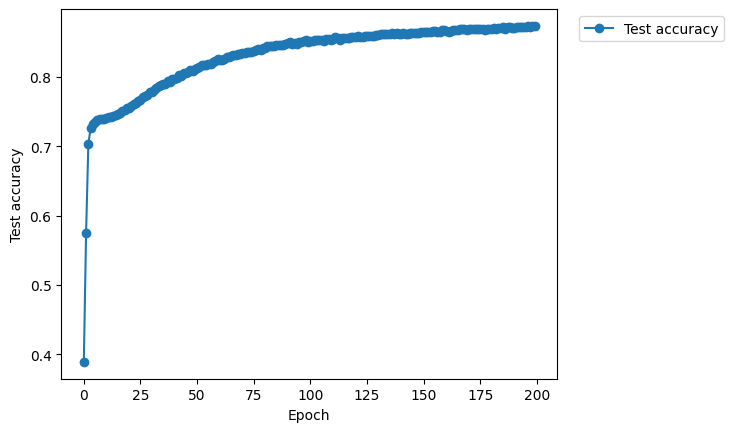

In [46]:
plt.plot(Epoch, Test_accuracy, marker='o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.legend(bbox_to_anchor=( 1.35, 1.))
plt.show()

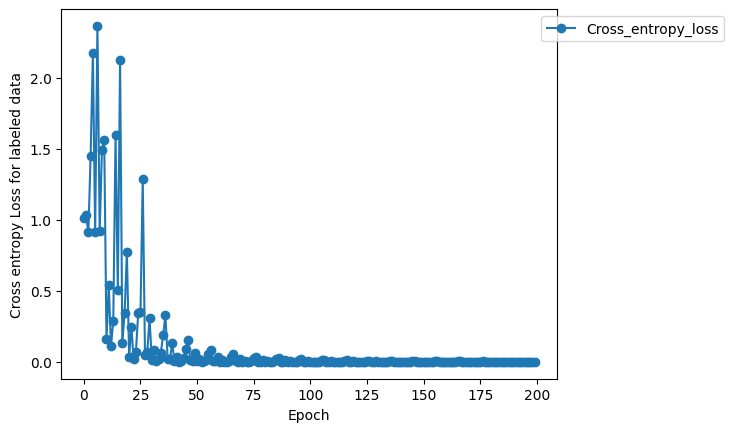

In [44]:
plt.plot(Epoch,Cross_entropy_loss[0:2000:10], marker='o', label='Cross_entropy_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross entropy Loss for labeled data')
plt.legend(bbox_to_anchor=( 1.35, 1.))
plt.show()

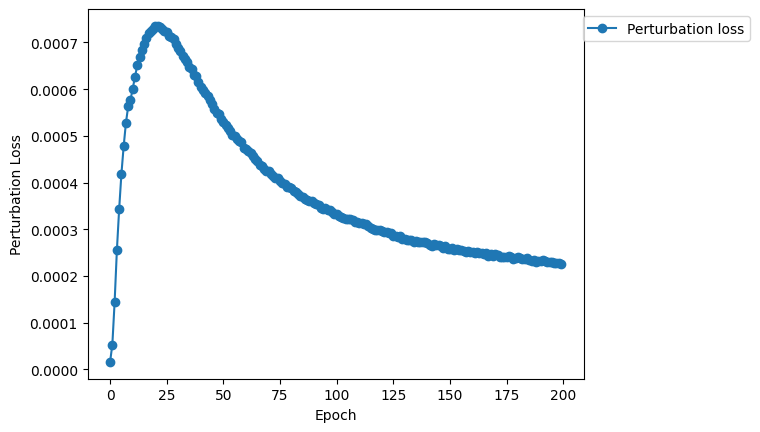

In [42]:
plt.plot(Epoch,Pertubation_loss, marker='o', label='Perturbation loss')
plt.xlabel('Epoch')
plt.ylabel('Perturbation Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))
plt.show()

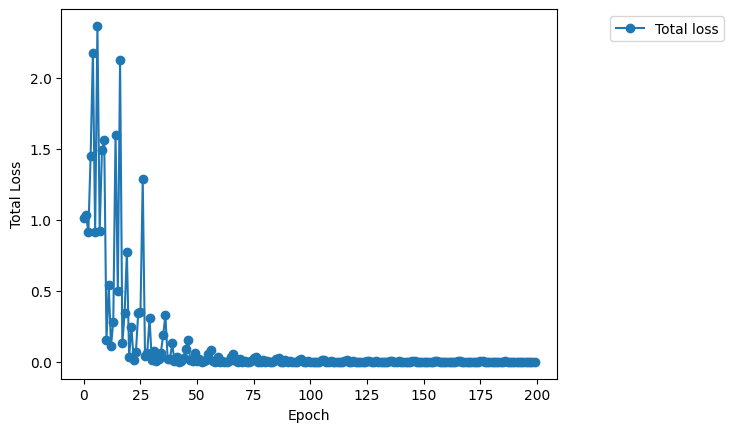

In [43]:
plt.plot(Epoch, Total_loss[0:2000:10], marker='o', label='Total loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))
plt.show()